In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Carga y preprocesado de Datos

El primer paso que debemos realizar es cargar y preparar el conjunto de datos con el que entrenaremos nuestra red neuronal

In [ ]:
from google.colab import files
#files.upload()
path_data = '/content/drive/MyDrive/datos_secuenciales/RNN/rnn.txt'

En este caso el proyecto se aborda a nivel de caracter, por lo que se puede considerar que el corpus son los caracteres y, por tanto, seria un corpus muy pequeño.

Cabe recordar que las redes neuronales solo procesan valores numericos, no letras. por lo tanto debemos traducir los caracteres a representacion numerica. para ello crearemos dos tablas de traduccion: una de caracteres a numeros y otra de numeros a caracteres:

In [ ]:
text = open(path_data,'rb').read().decode(encoding='utf-8')
print('Longitud del texto: {} carácteres'.format(len(text)))
vocab = sorted(set(text))

print('El texto está compuesto de esstos {} caráteres:'.format(len(vocab)))
print(vocab)

Longitud del texto: 203249 carácteres
El texto está compuesto de esstos 92 caráteres:
['\n', '\r', ' ', '!', '"', '#', '%', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xad', 'ÿ', 'Š', '‡', '…']


Ahora tenemos un token con la representacion de entero (integer) para cada caracter, como podemos ver ejecutando el siguiente codigo:

In [ ]:
#traduciendo letras a numeros. para ello es necesario crear dos tablas donde una sera la traduccion de texto a numero
#y otra de numero a texto
import numpy as np

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

for char,_ in zip(char2idx,range(len(vocab))):
  print(' {:4s}: {:3d},'.format(repr(char), char2idx[char]))

 '\n':   0,
 '\r':   1,
 ' ' :   2,
 '!' :   3,
 '"' :   4,
 '#' :   5,
 '%' :   6,
 "'" :   7,
 '(' :   8,
 ')' :   9,
 '*' :  10,
 '+' :  11,
 ',' :  12,
 '-' :  13,
 '.' :  14,
 '/' :  15,
 '0' :  16,
 '1' :  17,
 '2' :  18,
 '3' :  19,
 '4' :  20,
 '5' :  21,
 '6' :  22,
 '7' :  23,
 '8' :  24,
 '9' :  25,
 ':' :  26,
 ';' :  27,
 '<' :  28,
 '=' :  29,
 '>' :  30,
 '?' :  31,
 '@' :  32,
 'A' :  33,
 'B' :  34,
 'C' :  35,
 'D' :  36,
 'E' :  37,
 'F' :  38,
 'G' :  39,
 'H' :  40,
 'I' :  41,
 'J' :  42,
 'K' :  43,
 'L' :  44,
 'M' :  45,
 'N' :  46,
 'O' :  47,
 'P' :  48,
 'Q' :  49,
 'R' :  50,
 'S' :  51,
 'T' :  52,
 'U' :  53,
 'V' :  54,
 'W' :  55,
 'X' :  56,
 'Y' :  57,
 '[' :  58,
 ']' :  59,
 '_' :  60,
 'a' :  61,
 'b' :  62,
 'c' :  63,
 'd' :  64,
 'e' :  65,
 'f' :  66,
 'g' :  67,
 'h' :  68,
 'i' :  69,
 'j' :  70,
 'k' :  71,
 'l' :  72,
 'm' :  73,
 'n' :  74,
 'o' :  75,
 'p' :  76,
 'q' :  77,
 'r' :  78,
 's' :  79,
 't' :  80,
 'u' :  81,
 'v' :  82,
 'w'

y con esta funcion, inversa a la anterior, podemos pasar el texto a enteros:

In [ ]:
text_as_int = np.array([char2idx[c] for c in text])
#Para comprobar de que el texto ahora es representado por numeros, procederemos a imprimir los primeros 50 caracteres de nuestro texto

print('texto: {}'.format(repr(text[:50])))
print('texto: {}'.format(repr(text_as_int[:50])))

texto: 'Prologo\r\nEn 1953, Isaac Asimov publico Segunda Fun'
texto: array([48, 78, 75, 72, 75, 67, 75,  1,  0, 37, 74,  2, 17, 25, 21, 19, 12,
        2, 41, 79, 61, 61, 63,  2, 33, 79, 69, 73, 75, 82,  2, 76, 81, 62,
       72, 69, 63, 75,  2, 51, 65, 67, 81, 74, 64, 61,  2, 38, 81, 74])


# Preparacion de los datos para ser usados por la RNN

para entrenar nuestro modelo, preparamos unas secuencias de caracteres como entrada y salida de un tamaño determinado. En nuestra implementacion el tamaño es de 100 como se define en la variable seq_length.

In [ ]:
import tensorflow as tf
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #funcion que crea un conjunto de datos con el contenido del tensor (text_as_int) el cual contiene el texto
seq_length = 100
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) #Empezamos diviendo el texto el texto en secuencias de seq_length+1. con estos contruiremos los datos de entrenamiento

for item in sequences.take(10):
  print(repr(''.join(idx2char[item.numpy()])))
  # vamos a comprobar que sequences contiene el texto dividido en paquetes de 101 caracteres, mostrando las 10 primeras sequencias

'Prologo\r\nEn 1953, Isaac Asimov publico Segunda Fundacion, el tercer libro de la saga de la Fundacion '
'(o el decimotercero segun otras fuentes, este es un tema de debate). En Segunda Fundacion aparece por'
' primera vez Arkady Darell, uno de los principales personajes de la parte final de la saga. En su pri'
'mera escena, Arkady, que tiene 14 anos, esta haciendo sus tareas escolares. En concreto, una redaccio'
'n que lleva por titulo ?El Futuro del Plan Sheldon?. Para hacer la redaccion, Arkady esta utilizando '
'un ?transcriptor?,un dispositivo que convierte su voz en palabras escritas. Este tipo de dispositivo,'
' que para Isaac Asimov era ciencia ficcion en 1953, lo tenemos al alcance de la mano en la mayoria de'
' nuestros smartphones, y el Deep Learning es uno de los responsables de que ya tengamos este tipo de '
'aplicaciones, siendo la tecnologia otro de ellos.En la actualidad disponemos de GPUs (Graphics Proces'
'sor Units), que solo cuestan alrededor de 100 euros, que esta

De esta secuencia se obtiene el conjunto de datos de entrenamiento que contiene tanto los datos de entrada ( desde la posicion 0 a la 99) como los datos de ssalida
(desde la posicion 1 a la 100). para ello, se crea una funcion que realiza esta tarea y se aplicca a todas las secuencias usando el metodo map ()

In [ ]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

En este punto, dataset contiene un conjunto de parejass de secuencias de texto (con la representacion numerica de los caracteres) donde el primer componente de la pareja contiene un paquete con una secuencia de 100 caracteres del texto original, y el segundo contiene su correspondiente salida (etiqueta), tambien de 100 caracteres. Podemos comprobarlo visualizando la primera pareja de datos originales y su respetiva etiqueta

In [ ]:
#visualizaremos los datos tanto de entrada como de salida. los cuales deben ser los mismos
for input_example, target_example in dataset.take(1):
  print ('Input data:', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data: 'Prologo\r\nEn 1953, Isaac Asimov publico Segunda Fundacion, el tercer libro de la saga de la Fundacion'
Target data: 'rologo\r\nEn 1953, Isaac Asimov publico Segunda Fundacion, el tercer libro de la saga de la Fundacion '


In [ ]:
print(dataset)

<MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True) #indica el tamaño del paquete de los datos que se van a barajar
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


## Construccion del modelo RNN

para construir nuestro modelo usaremos solo una capa LSTM. En conreto, definimos una red de 3 capas:

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
  model = Sequential()

#Capa Embedding: permite especificar varios argumentos como el tamaño del vocabulario (vocab_size) que indica cuantos vectores tendra la capa
# (embedding_dim), indica las dimensiones de los vectores embedding que en nuestro caso seran de 256
# finalmente, se indica el tamaño del batch que usaremos para entrenar, en nuestro caso es de 64

  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      batch_input_shape=[batch_size, None]))
  
# Capa LSTM: en esta capa solo indicaremos el numero de neuronas recurrentes, con el argumento (rnn_units) y que en nuestro caso hemos decidido que sea de 1024 neuronas
# con return_sequences se indica que queremos predecir el caracter siguiente a todos los caracteres de entrada, no solo el siguiente al ultimo caracter
# el argumento recurrent_kernel indica como se deben inicializar los pesos de las matrices internas de la red. en nuestro caso se usa la distribucion uniforme (glorot_uniform)
  model.add(LSTM(rnn_units,
                 return_sequences=True,
                 stateful=True,
                 recurrent_initializer='glorot_uniform'))

#Capa densa: el unico parametro que se indica es el numero de neuronas, y que nos marcara la dimension de la salida.
  model.add(Dense(vocab_size))
  return model
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model = build_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23552     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 92)            94300     
                                                                 
Total params: 5,364,828
Trainable params: 5,364,828
Non-trainable params: 0
_________________________________________________________________


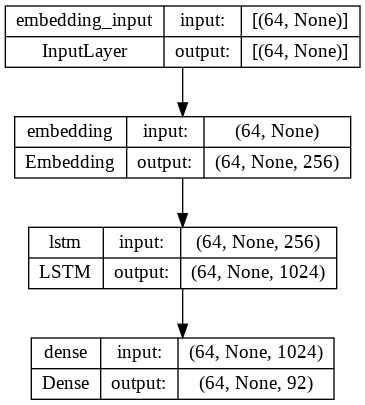

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  print('Input:',input_example_batch.shape, '# (batch_size,sequence_lenght)')
  print('Target:',target_example_batch.shape, '# (batch_size,sequence_lenght)')

Input: (64, 100) # (batch_size,sequence_lenght)
Target: (64, 100) # (batch_size,sequence_lenght)


In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_bacth_predictions = model(input_example_batch)
  print('Predicition: ', example_bacth_predictions.shape,
        '# (batch_size, sequence_lenght, vocab_size)')

Predicition:  (64, 100, 92) # (batch_size, sequence_lenght, vocab_size)


In [ ]:
# con tf.random.categorical se obtiene una muestra de distribucion categorica y con squeeze se eliminan las dimensiones del tensor de tamaño 1
#de este modo siempre se obtiene una prediccion del indice del siguiente caracter
sampled_indices = tf.random.categorical(
    example_bacth_predictions[0],
    num_samples=1
)
sampled_indices_characteres = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
print(sampled_indices_characteres)

[ 7  8 23 47 14 18 61 67 68 52 54 65  6 10 40 20 74 91 44 32  2 32 26 11
 72  0 11  9 34 91 22 37  4 61 72 16 63 13 32 44 51 24 54 35 25  7 61 77
 64 53  0  9 57  6 83 68 78 15 12 39 46 59 40  5 71  9 61 44 54 43 28 39
 22 24 51 91 33 33 90  9 42 28 55 69 64 12 80 87 15 65 58  7 54 15 21 68
 81 82 78 64]


## Entrenamiento del modelo RNN

In [ ]:
#entrenando el modelo
def loss(labels,logist):
  return tf.keras.losses.sparse_categorical_crossentropy(labels,logist,from_logits=True)

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
import os
chkpoint = './training_chkpoint'
chkpoint_prefix= os.path.join(chkpoint, 'ckpt_{epoch}')

chkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=chkpoint_prefix,
                                                     save_weights_only=True)

In [ ]:
EPOCHS = 50
history = model.fit(dataset,epochs=EPOCHS,callbacks=[chkpoint_callback])

Epoch 1/50
31/31 [==============================] - 188s 6s/step - loss: 3.4111
Epoch 2/50
31/31 [==============================] - 186s 6s/step - loss: 2.9182
Epoch 3/50
31/31 [==============================] - 190s 6s/step - loss: 2.6235
Epoch 4/50
31/31 [==============================] - 187s 6s/step - loss: 2.4267
Epoch 5/50
31/31 [==============================] - 182s 6s/step - loss: 2.2907
Epoch 6/50
31/31 [==============================] - 184s 6s/step - loss: 2.1987
Epoch 7/50
31/31 [==============================] - 187s 6s/step - loss: 2.1260
Epoch 8/50
31/31 [==============================] - 201s 6s/step - loss: 2.0583
Epoch 9/50
31/31 [==============================] - 187s 6s/step - loss: 1.9889
Epoch 10/50
31/31 [==============================] - 185s 6s/step - loss: 1.9184
Epoch 11/50
31/31 [==============================] - 187s 6s/step - loss: 1.8485
Epoch 12/50
31/31 [==============================] - 185s 6s/step - loss: 1.7782
Epoch 13/50
31/31 [==================

In [ ]:
!ls training_chkpoint

checkpoint		     ckpt_33.data-00000-of-00001
ckpt_10.data-00000-of-00001  ckpt_33.index
ckpt_10.index		     ckpt_34.data-00000-of-00001
ckpt_11.data-00000-of-00001  ckpt_34.index
ckpt_11.index		     ckpt_35.data-00000-of-00001
ckpt_12.data-00000-of-00001  ckpt_35.index
ckpt_12.index		     ckpt_36.data-00000-of-00001
ckpt_13.data-00000-of-00001  ckpt_36.index
ckpt_13.index		     ckpt_37.data-00000-of-00001
ckpt_14.data-00000-of-00001  ckpt_37.index
ckpt_14.index		     ckpt_38.data-00000-of-00001
ckpt_15.data-00000-of-00001  ckpt_38.index
ckpt_15.index		     ckpt_39.data-00000-of-00001
ckpt_16.data-00000-of-00001  ckpt_39.index
ckpt_16.index		     ckpt_3.data-00000-of-00001
ckpt_17.data-00000-of-00001  ckpt_3.index
ckpt_17.index		     ckpt_40.data-00000-of-00001
ckpt_18.data-00000-of-00001  ckpt_40.index
ckpt_18.index		     ckpt_41.data-00000-of-00001
ckpt_19.data-00000-of-00001  ckpt_41.index
ckpt_19.index		     ckpt_42.data-00000-of-00001
ckpt_1.data-00000-of-00001   ckpt_42.index
ckpt

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(chkpoint))
model.build(tf.TensorShape([1,None]))

## Generacion de texto usando el modelo RNN
ya que nuestro modelo se ha entrenado, es posible hacer uso de el para generar texto y lo haremos a partir de una palabra.

In [ ]:
def generate_text(model,start_string):
  num_generate = 500 #numero de caracteres a predecir
  input_eval = [char2idx [s] for s in start_string]
  input_eval = tf.expand_dims(input_eval,0)
  text_generated=[]
  temperature = 0.5 #variable definida como humbral (hasta 1) ya que el modelo puede recibir una palabra con errores de ortografia
  #con una tolerancia mas alta, el modelo tendra mas creatividad, pero dara mas errores. mientras que si tolerancia es menor
  #mostrara menos creatividad y sus errores seran pocos
  model.reset_states()

  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions,0)

    predictions = predictions/temperature
    predicted_id = tf.random.categorical(predictions, num_samples = 1)[-1,0].numpy()

    input_eval = tf.expand_dims([predicted_id],0)
    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model,start_string=u'domingo '))

domingo de aprendizaje supervisado por un conjunto de datos MNIST a la segunda parte del libro esta mismo ya hemos visto anteriormente por el modelo predictos y menos mas complejas en la capa de convolucion y el modelo en cambio, la arcalizacion de la red neuronal con Keras. Concretamente programar el disto principal de cada uno de los parametros (pesos y sesgo b) para el numero de epochs para la columnar en la siguiente figura podemos ver el modelo presenta el tipo de datos que permite a cada represent
